In [1]:
%autosave 1
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.stats as stats


Autosaving every 1 seconds


## PV with square activation function and square in learning rule

In [2]:
def phi_square(_x):
    x = np.array([_x])
    x[x<=0] = 0
    x[x>0] = x[x>0]**2 
    x[x>20] = 20
    return x[0]

In [3]:
def phi(x_,case=1):
    x = np.array([x_])
    if case == 1:
        x[x<=0] = 0
        x[x>20] = 20
    return x[0]

In [322]:
def plot_PVratesandweights(results1,results2,name):
    plt.figure(figsize=(7,4))
    a5 = plt.subplot(121)
    plt.plot(results1['wPX1'], label='high', color =cm.viridis(.1),linewidth=2)
    plt.plot(results2['wPX1'], label='low',color =cm.viridis(.5),linewidth=2)
    plt.plot(np.arange(len(wPX1_monitor)),np.ones(len(wPX1_monitor))*Y1_sigma,'--',color =cm.viridis(.1),label=r'$\sigma$ high')
    plt.plot(np.arange(len(wPX1_monitor)),np.ones(len(wPX1_monitor))*Y2_sigma,'--',color =cm.viridis(.5),label=r'$\sigma$ low')

    plt.ylabel('PV weights',fontsize=16)
    plt.xlabel('time',fontsize=16)
    plt.yticks(np.arange(0,1.1,0.2),[0,0.2,.4,.6,.8,1.0],fontsize=16)
    plt.xticks([0,300000],[0,300000],fontsize=16)
    #plt.ylim(0,1.25)
    #plt.xlim(0,11000)
    lgd = plt.legend(loc='lower right',fontsize=11)
    a5.spines['top'].set_visible(False)
    a5.spines['right'].set_visible(False)

    a2 = plt.subplot(122)
    plt.plot(np.arange(-1,3),np.ones(4)*Y1_sigma**2,'--',color =cm.viridis(.1),label=r'$\sigma^2$ high')
    plt.plot(np.arange(-1,3),np.ones(4)*Y2_sigma**2,'--',color =cm.viridis(.5),label=r'$\sigma^2$ low')
    plt.bar([0,1],[results1['PV_avg'],results2['PV_avg']],yerr=[results1['PV_std'],results2['PV_std']],color=[cm.viridis(.1),cm.viridis(.5)],width=0.3)
    plt.ylabel('PV rate',fontsize=16)
    plt.xticks([0,1],['high','low'],fontsize=16)
    plt.xlabel('uncertainty',fontsize=16)
    plt.yticks(np.arange(0,1.3,0.2),[0,0.2,.4,.6,.8,1.0,1.2],fontsize=16)
    #plt.yticks([0,2],[0,2],fontsize=16)
    a2.spines['top'].set_visible(False)
    a2.spines['right'].set_visible(False)
    #plt.ylim(0,2.3)
    plt.xlim(-0.5,1.5)
    plt.tight_layout()
    plt.legend(fontsize=11)
    plt.savefig('./PVratesandweights_%s.png'%name, bbox_inches='tight',rasterized=True)


In [333]:
def run_pPEnetwork(mean= 5.0, sigma= 0.5, SSTrate=None,wP=np.sqrt(20), w_init_PVX = 0.01, w_init_PVS = 0.01, w_init_R = 0.1, plastic=True, plastic_PX=True,plastic_PS=False, rectified=1):
    """
    Parameters
    ----------
    mean : float
        mean of the stimulus distribution
    sigma: float
        standard deviation of the stimulus distribution
    wP : float
        connection weight from R to PV and from SST to PV
    w_init_PV : float
        initial weight from Y1 to PV
    w_init_R : float
        initial weight from Y1 to R
    plastic : boolean
        truth value indicates whether plasticity is switched on or off   
        
    Returns
    ----------
    E_avg : float
        mean rate of error neuron
    PV_avg : float
        mean rate of PV
    SST_avg : float
        mean rate of SST
    R_avg : float
        mean rate of R
    wPX1_monitor : array of length t
        weight from X1 to PV over the course of the simulation
    wRX1_monitor : array of length t
        weight from X1 to R over the course of the simulation
    rE_monitor : array of length t
        rate of error neuron over the course of the simulation
    rS_monitor : array of length t
        rate of error neuron over the course of the simulation
    rP_monitor : array of length t
        rate of error neuron over the course of the simulation
    rY1 : array of length t
        whisker deflections over the course of the simulation
    """
    
    #sim parameters
    dt = 1
    T = 300000 # number of time steps

    # time constants
    tau_P = 1.0
    tau_S = 1.0
    tau_E = 1.0
    tau_R = 1.0

    # weights
    # to PV
    wPX1 = np.array([w_init_PVX]) # small intitial weights
    wPY1 = np.array([wP]) # small intitial weights
    if plastic_PS:
        wPS = np.array([w_init_PVS])
    else:
        wPS = np.array([wP])

    # to Representation neuron
    wRX1 = np.array([w_init_R]) # small intitial weight
    wRY1 = np.array([1.0])
    
    # to SST
    wSR = np.array([1.0])

    # to E
    wEP = np.array([1.0])
    wES = np.array([1.0])
    wEY1 = np.array([1.0])

    # nudging parameter
    beta_R = 0.1 
    beta_P = 0.1


    # inputs
    # sound
    rX1 = np.ones((T))

    # whisker
    Y1_mean = mean
    Y1_sigma = sigma

    rY1 = Y1_sigma*np.random.randn(T)+Y1_mean
    
    # test
    if SSTrate is None:
        rS = np.ones(T)*Y1_mean
    else:
        rS = np.ones(T)*SSTrate
        
    #learning rate
    eta_R = 0.1
    eta_P = 0.001
    eta_ES = 0.001

    #initial rates
    rP = 0.0#phi_square(rB[0])
    #rS = 0.0
    rE = 0.0
    rR = 0.0

    # monitors
    rP_monitor = np.empty((T))
    rE_monitor = np.empty((T))
    rS_monitor = np.empty((T))
    rR_monitor = np.empty((T))

    wPX1_monitor = np.empty((T))
    wRX1_monitor = np.empty((T))
    wPS_monitor = np.empty((T))
    wES_monitor = np.empty((T))


    for t in range(T):
        #drR = (-rR + phi((1-beta_R)*(wRX1 * rX1[t]) + beta_R*(wRY1 * rY1[t]),case=rectified))/tau_R
        #drS = (-rS + phi(wSR * rR,case=rectified))/tau_S
        drP = (-rP + phi_square(((1-beta_P)*(wPX1 * rX1[t]) + beta_P *(wPY1 * rY1[t] - wPS * rS[t]))))/tau_P
        drE = (-rE + phi(1.0/(1.0 + wEP * rP) * (wEY1 * rY1[t] - wES * rS[t]),case=rectified))/tau_E

        # store monitors
        rP_monitor[t] = rP
        #rS_monitor[t] = rS
        rE_monitor[t] = rE
        rR_monitor[t] = rR
        wPX1_monitor[t] = wPX1
        wRX1_monitor[t] = wRX1
        wPS_monitor[t] = wPS
        wES_monitor[t] = wES


        # rate changes
        #rR += dt*drR
        #rS += dt*drS
        rP += dt*drP
        rE += dt*drE

        # weight changes
        dwPX1 = plastic_PX * eta_P * ((rP - phi_square(wPX1*rX1[t])) * rX1[t])
        #dwPX1 = plastic * eta_P * (((wPY1 * rY1[t] - wPS * rS[t]) - (wPX1*rX1[t])) * rX1[t])

        dwRX1 = plastic * eta_R * ((rR - (wRX1*rX1[t])) * rX1[t])
        dwPS = plastic_PS * eta_P * (wPY1 * rY1[t] - wPS * rS[t])*rS[t]
        #dwES = plastic * eta_ES * ((wEY1 * rY1[t] - wES * rS))*rS
        
        #wRE_P += plastic * eta_RE * (wRE_P*rE_P - wRE_N*rE_N) * rE_P
        #wRE_N += plastic * eta_RE * (wRE_P*rE_P - wRE_N*rE_N) * rE_N

        wPX1 += dt*dwPX1
        wRX1 += dt*dwRX1
        wPS += dt*dwPS
        #wES += dt*dwES

    
    PV_avg = np.mean(rP_monitor[100:])
    SST_avg = np.mean(rS_monitor[100:])
    E_avg = np.mean(rE_monitor[100:])
    R_avg = np.mean(rR_monitor[100:])
    PV_std = np.std(rP_monitor[100:])
    SST_std = np.std(rS_monitor[100:])
    E_std = np.std(rE_monitor[100:])
    R_std = np.std(rR_monitor[100:])
    
    rS_monitor = rS
    
    results = {
    'PV_avg' : np.mean(rP_monitor[100:]),
    'SST_avg': np.mean(rS_monitor[100:]),
    'E_avg' : np.mean(rE_monitor[100:]),
    'R_avg' : np.mean(rR_monitor[100:]),
    'PV_std' : np.std(rP_monitor[100:]),
    'SST_std': np.std(rS_monitor[100:]),
    'E_std' : np.std(rE_monitor[100:]),
    'R_std' : np.std(rR_monitor[100:]),
    'wPX1' : wPX1_monitor,
    'wRX1' : wRX1_monitor, 
    'wPS' : wPS_monitor, 
    'wES' : wES_monitor, 
    #'wRE' : wRE_monitor, 
    'rE' : rE_monitor, 
    'rS' : rS_monitor, 
    'rP' : rP_monitor, 
    'rR' : rR_monitor, 
    'rY1' : rY1,
    }
    
    return results
    

In [351]:
Y1_mean = 5.0
Y2_mean = 5.0
Y1_sigma = 0.8
Y2_sigma = 0.4
results1 = run_pPEnetwork(mean= Y1_mean,sigma=Y1_sigma,wP=np.sqrt(20))#4.4)
results2 = run_pPEnetwork(mean= Y2_mean,sigma=Y2_sigma,wP=np.sqrt(20))#4.4)

<ipython-input-322-cad3f6f51d74>:34: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('./PVratesandweights_%s.png'%name, bbox_inches='tight',rasterized=True)


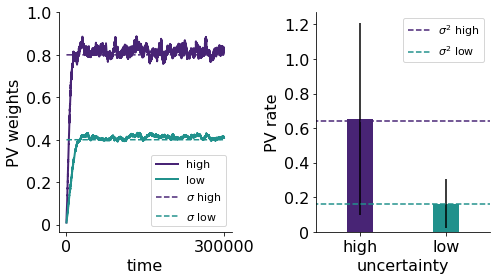

In [352]:
plot_PVratesandweights(results1,results2,'')


In [324]:
Y1_mean = 5.0
Y2_mean = 5.0
Y1_sigma = 0.8
Y2_sigma = 0.4
results1_plasticPS = run_pPEnetwork(mean= Y1_mean,sigma=Y1_sigma,wP=np.sqrt(20),plastic_PS=True)#4.4)
results2_plasticPS = run_pPEnetwork(mean= Y2_mean,sigma=Y2_sigma,wP=np.sqrt(20),plastic_PS=True)

<ipython-input-287-32c35629b376>:33: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('./PVratesandweights_plasticPS.png', bbox_inches='tight',rasterized=True)


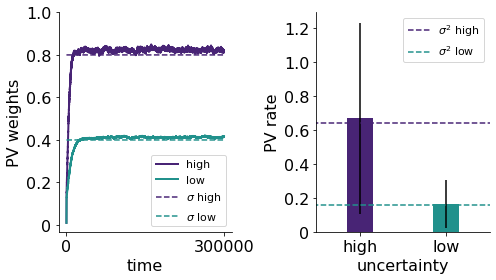

In [287]:
plot_PVratesandweights(results1_plasticPS,results2_plasticPS,'_plasticPS')

In [440]:
results1new = run_network(mean= Y1_mean+0.182,sigma=0.0,SSTrate=Y1_mean,wP=np.sqrt(20),w_init_R= results1['wRX1'][-1],w_init_PVX=results1['wPX1'][-1],plastic_PX=False)#4.4)
results2new = run_network(mean= Y2_mean+0.182,sigma=0.0,SSTrate=Y1_mean,wP=np.sqrt(20),w_init_R= results2['wRX1'][-1],w_init_PVX=results2['wPX1'][-1],plastic_PX=False)

In [363]:
results1['wPX1'][-1]

0.8147049971690605

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


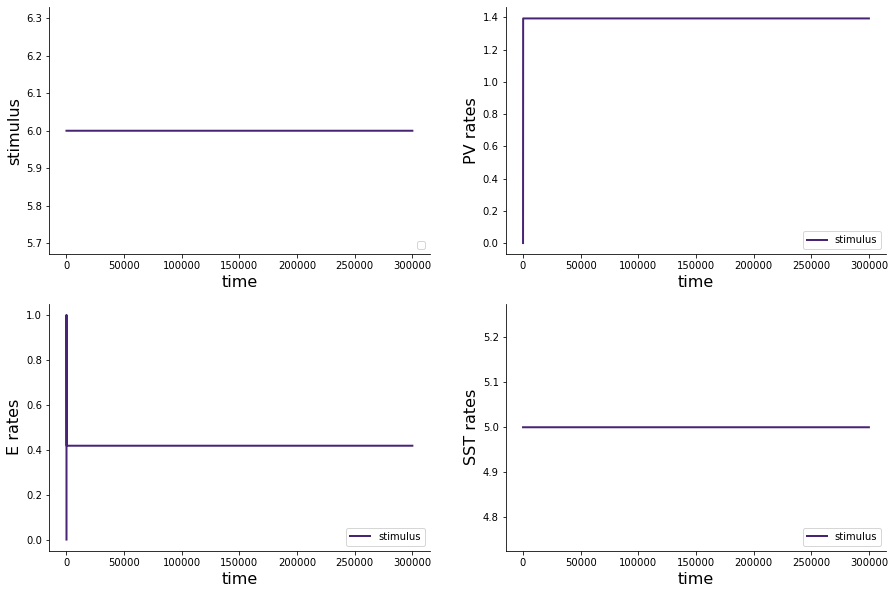

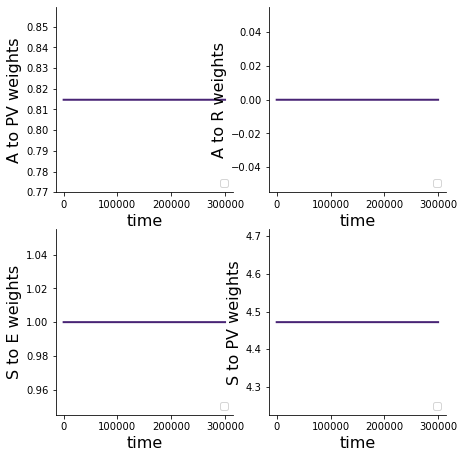

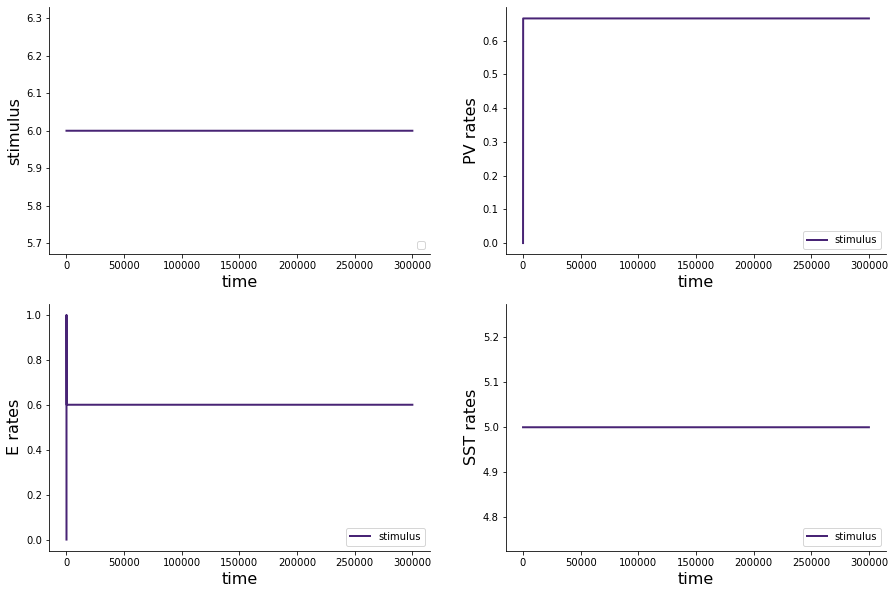

In [364]:
plot_all_rates(results1new,name='new')
plot_all_weights(results1new,name='new')
plot_all_rates(results2new,name='new')


In [365]:
def plot_all_rates(results1,name):
    plt.figure(figsize=(15,10))

    a0 = plt.subplot(221)
    plt.plot(results1['rY1'], color =cm.viridis(.1),linewidth=2)
    plt.ylabel('stimulus',fontsize=16)
    plt.xlabel('time',fontsize=16)
    #plt.yticks([0,1],[0,1],fontsize=16)
    #plt.xticks([0,10000],[0,10000],fontsize=16)
    #plt.ylim(0,1.25)
    #plt.xlim(0,11000)
    plt.legend(loc='lower right')
    a0.spines['top'].set_visible(False)
    a0.spines['right'].set_visible(False)

    a0 = plt.subplot(222)
    plt.plot(results1['rP'], label='stimulus', color =cm.viridis(.1),linewidth=2)
    plt.ylabel('PV rates',fontsize=16)
    plt.xlabel('time',fontsize=16)
    #plt.yticks([0,1],[0,1],fontsize=16)
    #plt.xticks([0,10000],[0,10000],fontsize=16)
    #plt.ylim(0,1.25)
    #plt.xlim(0,11000)
    plt.legend(loc='lower right')
    a0.spines['top'].set_visible(False)
    a0.spines['right'].set_visible(False)


    a0 = plt.subplot(223)
    plt.plot(results1['rE'], label='stimulus', color =cm.viridis(.1),linewidth=2)
    plt.ylabel('E rates',fontsize=16)
    plt.xlabel('time',fontsize=16)
    #plt.yticks([0,1],[0,1],fontsize=16)
    #plt.xticks([0,10000],[0,10000],fontsize=16)
    #plt.ylim(0,1.25)
    #plt.xlim(0,11000)
    plt.legend(loc='lower right')
    a0.spines['top'].set_visible(False)
    a0.spines['right'].set_visible(False)

    a0 = plt.subplot(224)
    plt.plot(results1['rS'], label='stimulus', color =cm.viridis(.1),linewidth=2)
    plt.ylabel('SST rates',fontsize=16)
    plt.xlabel('time',fontsize=16)
    #plt.yticks([0,1],[0,1],fontsize=16)
    #plt.xticks([0,10000],[0,10000],fontsize=16)
    #plt.ylim(0,1.25)
    #plt.xlim(0,11000)
    plt.legend(loc='lower right')
    a0.spines['top'].set_visible(False)
    a0.spines['right'].set_visible(False)


In [366]:
def plot_all_weights(results,name):
    plt.figure(figsize=(7,7.5))
    a0 = plt.subplot(221)
    plt.plot(results['wPX1'], color =cm.viridis(.1),linewidth=2)
    plt.ylabel('A to PV weights',fontsize=16)
    plt.xlabel('time',fontsize=16)
    #plt.yticks([0,1],[0,1],fontsize=16)
    #plt.xticks([0,10000],[0,10000],fontsize=16)
    #plt.ylim(0,1.25)
    #plt.xlim(0,11000)
    plt.legend(loc='lower right')
    a0.spines['top'].set_visible(False)
    a0.spines['right'].set_visible(False)



    #plt.legend(loc='lower right')
    a6 = plt.subplot(222)
    plt.plot(results['wRX1'], color =cm.viridis(.1),linewidth=2)
    plt.ylabel('A to R weights',fontsize=16)
    plt.xlabel('time',fontsize=16)
    #plt.yticks([0,1],[0,1],fontsize=16)
    #plt.xticks([0,10000],[0,10000],fontsize=16)
    #plt.ylim(0,1.25)
    #plt.xlim(0,11000)
    plt.legend(loc='lower right')
    a6.spines['top'].set_visible(False)
    a6.spines['right'].set_visible(False)

    a0 = plt.subplot(223)
    plt.plot(results['wES'], color =cm.viridis(.1),linewidth=2)
    plt.ylabel('S to E weights',fontsize=16)
    plt.xlabel('time',fontsize=16)
    #plt.yticks([0,1],[0,1],fontsize=16)
    #plt.xticks([0,10000],[0,10000],fontsize=16)
    #plt.ylim(0,1.25)
    #plt.xlim(0,11000)
    plt.legend(loc='lower right')
    a0.spines['top'].set_visible(False)
    a0.spines['right'].set_visible(False)



    #plt.legend(loc='lower right')
    a6 = plt.subplot(224)
    plt.plot(results['wPS'], color =cm.viridis(.1),linewidth=2)
    plt.ylabel('S to PV weights',fontsize=16)
    plt.xlabel('time',fontsize=16)
    #plt.yticks([0,1],[0,1],fontsize=16)
    #plt.xticks([0,10000],[0,10000],fontsize=16)
    #plt.ylim(0,1.25)
    #plt.xlim(0,11000)
    plt.legend(loc='lower right')
    a6.spines['top'].set_visible(False)
    a6.spines['right'].set_visible(False)

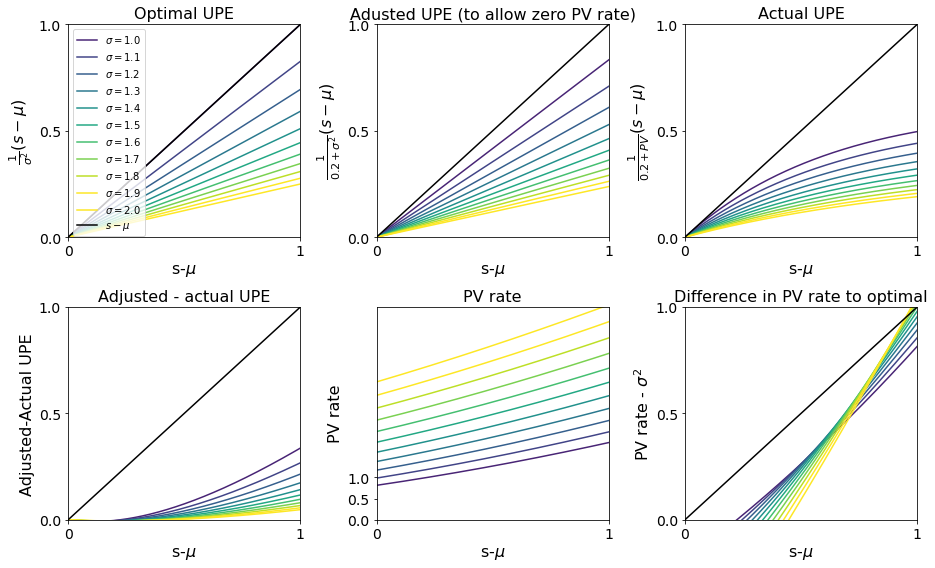

In [525]:

zoom=True
plt.figure(figsize=(13,8))
plt.subplot(231)
xrange=np.arange(0,10,0.0001)
for sigma in np.arange(1.0,2.1,0.1):
    plt.plot(xrange,(1.0/(sigma**2))*xrange,label=r'$\sigma=$%.1f'%sigma,color=cm.viridis(sigma-0.9))
plt.plot(xrange,xrange,label=r'$s-\mu$',color='k')

plt.xlabel(r's-$\mu$',fontsize=16)
plt.ylabel(r'$\frac{1}{\sigma^2}(s-\mu)$',fontsize=16)
plt.title('Optimal UPE',fontsize=16)
if zoom:
    plt.xticks(np.arange(11),np.arange(11),fontsize=14)
    plt.yticks(np.arange(0,1.1,0.5),np.arange(0,1.1,.5),fontsize=14)
    plt.xlim(0,1)
    plt.ylim(0,1)
plt.legend(loc='upper left')

plt.subplot(232)
xrange=np.arange(0,10,0.0001)
for sigma in np.arange(1.0,2.1,0.1):
    plt.plot(xrange,(1.0/(0.2 + (sigma**2)))*xrange,label=r'$\sigma=$%.1f'%sigma,color=cm.viridis(sigma-0.9))
plt.plot(xrange,xrange,label=r'$s-\mu$',color='k')

plt.xlabel(r's-$\mu$',fontsize=16)
plt.ylabel(r'$\frac{1}{0.2+\sigma^2}(s-\mu)$',fontsize=16)
plt.title('Adusted UPE (to allow zero PV rate)',fontsize=16)

if zoom:
    plt.xticks(np.arange(11),np.arange(11),fontsize=14)
    plt.yticks(np.arange(0,1.1,0.5),np.arange(0,1.1,.5),fontsize=14)
    plt.xlim(0,1)
    plt.ylim(0,1)
#plt.legend()

plt.subplot(233)
xrange=np.arange(0,10,0.0001)
for sigma in np.arange(1.0,2.1,0.1):
    plt.plot(xrange,(1.0/(0.2 + ((0.9*sigma + 0.1*xrange*np.sqrt(20))**2)))*xrange,label=r'$\sigma=$%.1f'%sigma,color=cm.viridis(sigma-0.9))
plt.plot(xrange,xrange,label=r'$s-\mu$',color='k')
plt.ylabel(r'$\frac{1}{0.2+PV}(s-\mu)$',fontsize=16)

plt.xlabel(r's-$\mu$',fontsize=16)
plt.title('Actual UPE',fontsize=16)
if zoom:
    plt.xticks(np.arange(11),np.arange(11),fontsize=14)
    plt.yticks(np.arange(0,1.1,0.5),np.arange(0,1.1,.5),fontsize=14)
    plt.xlim(0,1)
    plt.ylim(0,1)
#plt.legend()

plt.subplot(234)
xrange=np.arange(0,10,0.0001)
for sigma in np.arange(1.0,2.1,0.1):
    plt.plot(xrange,((1.0/(0.2 + (sigma**2)))*xrange) - ((1.0/(0.2 + ((0.9*sigma + 0.1*xrange*np.sqrt(20))**2)))*xrange),label=r'$\sigma=$%.1f'%sigma,color=cm.viridis(sigma-0.9))
plt.plot(xrange,xrange,label=r'$s-\mu$',color='k')
plt.ylabel(r'Adjusted-Actual UPE',fontsize=16)

plt.xlabel(r's-$\mu$',fontsize=16)
plt.title('Adjusted - actual UPE',fontsize=16)
if zoom:
    plt.xticks(np.arange(11),np.arange(11),fontsize=14)
    plt.yticks(np.arange(0,1.1,0.5),np.arange(0,1.1,.5),fontsize=14)
    plt.xlim(0,1)
    plt.ylim(0,1)
#plt.legend()


plt.subplot(235)
xrange=np.arange(0,10,0.0001)
for sigma in np.arange(1.0,2.1,0.1):
    plt.plot(xrange,(0.9*sigma + 0.1*xrange*np.sqrt(20))**2,label=r'$\sigma=$%.1f'%sigma,color=cm.viridis(sigma-0.9))
    #plt.plot(xrange,np.ones(len(xrange))*sigma**2,color=cm.viridis(sigma-0.9))
plt.xlabel(r's-$\mu$',fontsize=16)
plt.ylabel('PV rate',fontsize=16)
plt.title('PV rate',fontsize=16)
if zoom:
    plt.xticks(np.arange(11),np.arange(11),fontsize=14)
    plt.yticks(np.arange(0,1.1,0.5),np.arange(0,1.1,.5),fontsize=14)
    plt.xlim(0,1)
    plt.ylim(0,5)

#plt.plot(xrange,np.ones(len(xrange))*(results1['wPX1'][-1]))
#plt.xlim(0.18,.185)
#plt.ylim(0.8,.82)

plt.subplot(236)
xrange=np.arange(0,10,0.0001)
for sigma in np.arange(1.0,2.1,0.1):
    plt.plot(xrange,((0.9*sigma + 0.1*xrange*np.sqrt(20))**2) - sigma**2,label=r'$\sigma=$%.1f'%sigma,color=cm.viridis(sigma-0.9))
plt.plot(xrange,xrange,label=r'$s-\mu$',color='k')
plt.title('Difference in PV rate to optimal',fontsize=16)
plt.xlabel(r's-$\mu$',fontsize=16)
plt.ylabel(r'PV rate - $\sigma^2$',fontsize=16)
if zoom:
    plt.xticks(np.arange(11),np.arange(11),fontsize=14)
    plt.yticks(np.arange(0,1.1,0.5),np.arange(0,1.1,.5),fontsize=14)
    plt.xlim(0,1)
    plt.ylim(0,1)

plt.tight_layout()
name=''
if zoom:
    name=name+'zoom'
plt.savefig('./Errorscalingproblem%s.png'%(name), bbox_inches='tight')


In [433]:
print(Y1_sigma)
print(np.sqrt(20)*1.6396)
print(Y1_sigma**2)
print(0.1*np.sqrt(20)*1.6396)
print((0.9*Y1_sigma + 0.1*np.sqrt(20)*1.6396)**2)


0.8
7.332514111817311
0.6400000000000001
0.7332514111817311
2.111939664101693


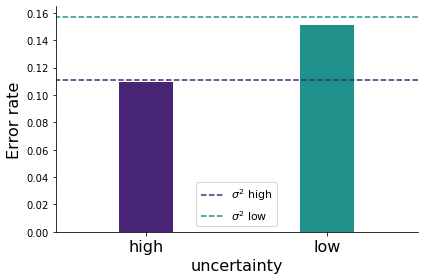

In [442]:


a2 = plt.subplot(111)
plt.plot(np.arange(-1,3),np.ones(4)*(1.0/(1.0+(Y1_sigma)**2.0)*0.182),'--',color =cm.viridis(.1),label=r'$\sigma^2$ high')
plt.plot(np.arange(-1,3),np.ones(4)*(1.0/(1.0+(Y2_sigma)**2.0)*0.182),'--',color =cm.viridis(.5),label=r'$\sigma^2$ low')

#plt.plot(np.arange(-1,3),np.ones(4)*(1.0/(1.0+(0.9*Y1_sigma+0.1*np.sqrt(20)*1.6396)**2)*1.6396),'--',color =cm.viridis(.1),label=r'$\sigma^2$ high')
#plt.plot(np.arange(-1,3),np.ones(4)*(1.0/(1.0+(0.9*Y2_sigma+0.1*np.sqrt(20)*1.6396)**2)*1.6396),'--',color =cm.viridis(.5),label=r'$\sigma^2$ low')
plt.bar([0,1],[results1new['E_avg'],results2new['E_avg']],yerr=[results1new['E_std'],results2new['E_std']],color=[cm.viridis(.1),cm.viridis(.5)],width=0.3)
plt.ylabel('Error rate',fontsize=16)
plt.xticks([0,1],['high','low'],fontsize=16)
plt.xlabel('uncertainty',fontsize=16)
#plt.yticks(np.arange(0,1.3,0.2),[0,0.2,.4,.6,.8,1.0,1.2],fontsize=16)
#plt.yticks([0,2],[0,2],fontsize=16)
a2.spines['top'].set_visible(False)
a2.spines['right'].set_visible(False)
#plt.ylim(0,2.3)
plt.xlim(-0.5,1.5)
plt.tight_layout()
plt.legend(fontsize=11)
#plt.savefig('./PVratesandweights_plasticPS.png', bbox_inches='tight',rasterized=True)

In [289]:
wPs = np.arange(1,6,1.0)
wPSs = np.empty_like(wPs)
for i,wP in enumerate(wPs):
    _, _, _, _, _, _, _, _, _, _, wPS, _, _, _, _,_ = run_network(sigma=0.1,wP=wP)
    wPSs[i] = wPS[-1]

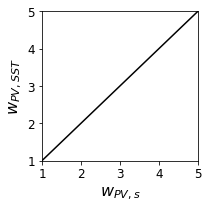

In [295]:
plt.figure(figsize=(3,3))
#plt.plot(sigmas, PV_avg*(1/np.sqrt(2)))
plt.subplot(111)
plt.plot(wPs, wPSs, color='k')
# works for wP=3.0
plt.xlim(1.0,5.0)
plt.ylim(1.0,5.0)
plt.xticks(np.arange(1,6),[1,2,3,4,5],fontsize=12)
plt.yticks(np.arange(1,6),[1,2,3,4,5],fontsize=12)
plt.xlabel(r'$w_{PV,s}$',fontsize=16)
plt.ylabel(r'$w_{PV,SST}$',fontsize=16)
plt.tight_layout()
plt.savefig('./PVSSTweightlearning.png', bbox_inches='tight')

<ipython-input-288-20e48fdbba9f>:105: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('./results_learnwPS.pdf', bbox_inches='tight',rasterized=True)


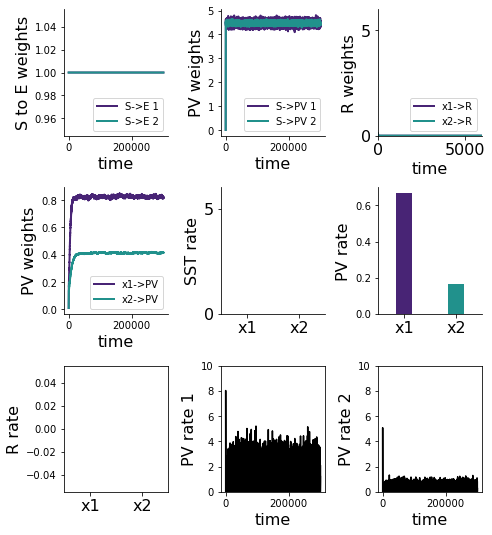

In [288]:
plt.figure(figsize=(7,7.5))
a0 = plt.subplot(331)
plt.plot(results1['wES'], label='S->E 1', color =cm.viridis(.1),linewidth=2)
plt.plot(results1['wES'], label='S->E 2',color =cm.viridis(.5),linewidth=2)
plt.ylabel('S to E weights',fontsize=16)
plt.xlabel('time',fontsize=16)
#plt.yticks([0,1],[0,1],fontsize=16)
#plt.xticks([0,10000],[0,10000],fontsize=16)
#plt.ylim(0,1.25)
#plt.xlim(0,11000)
plt.legend(loc='lower right')
a0.spines['top'].set_visible(False)
a0.spines['right'].set_visible(False)



#plt.legend(loc='lower right')
a6 = plt.subplot(332)
plt.plot(results1['wPS'], label='S->PV 1', color =cm.viridis(.1),linewidth=2)
plt.plot(results2['wPS'], label='S->PV 2',color =cm.viridis(.5),linewidth=2)
plt.ylabel('PV weights',fontsize=16)
plt.xlabel('time',fontsize=16)
#plt.yticks([0,1],[0,1],fontsize=16)
#plt.xticks([0,10000],[0,10000],fontsize=16)
#plt.ylim(0,1.25)
#plt.xlim(0,11000)
plt.legend(loc='lower right')
a6.spines['top'].set_visible(False)
a6.spines['right'].set_visible(False)



a1 = plt.subplot(333)
plt.plot(wRX1_monitor, label='x1->R', color =cm.viridis(.1),linewidth=2)
plt.plot(wRX2_monitor, label='x2->R',color =cm.viridis(.5),linewidth=2)
plt.ylabel('R weights',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.legend(loc='lower right')
plt.xlim(0,6000)
plt.xticks([0,5000],[0,5000],fontsize=16)
plt.ylim(0,6)
plt.yticks([0,5],[0,5],fontsize=16)
a1.spines['top'].set_visible(False)
a1.spines['right'].set_visible(False)

a5 = plt.subplot(334)
plt.plot(wPX1_monitor, label='x1->PV', color =cm.viridis(.1),linewidth=2)
plt.plot(wPX2_monitor, label='x2->PV',color =cm.viridis(.5),linewidth=2)
plt.ylabel('PV weights',fontsize=16)
plt.xlabel('time',fontsize=16)
#plt.yticks([0,1],[0,1],fontsize=16)
#plt.xticks([0,10000],[0,10000],fontsize=16)
#plt.ylim(0,1.25)
#plt.xlim(0,11000)
plt.legend(loc='lower right')
a5.spines['top'].set_visible(False)
a5.spines['right'].set_visible(False)


a3 = plt.subplot(335)
plt.bar([0,1],[SST_avg1,SST_avg2],color=[cm.viridis(.1),cm.viridis(.5)],width=0.3)  
plt.ylim(0,6)
plt.xlim(-0.5,1.5)
plt.yticks([0,5],[0,5],fontsize=16)
a3.spines['top'].set_visible(False)
a3.spines['right'].set_visible(False)
plt.ylabel('SST rate',fontsize=16)
plt.xticks([0,1],['x1','x2'],fontsize=16)

a2 = plt.subplot(336)
plt.bar([0,1],[PV_avg1,PV_avg2],color=[cm.viridis(.1),cm.viridis(.5)],width=0.3)
plt.ylabel('PV rate',fontsize=16)
plt.xticks([0,1],['x1','x2'],fontsize=16)
#plt.yticks([0,2],[0,2],fontsize=16)
a2.spines['top'].set_visible(False)
a2.spines['right'].set_visible(False)
#plt.ylim(0,2.3)
plt.xlim(-0.5,1.5)

a9 = plt.subplot(337)
plt.bar([0,1],[R_avg1,R_avg2],color=[cm.viridis(.1),cm.viridis(.5)],width=0.3)  
#plt.ylim(0,6)
plt.xlim(-0.5,1.5)
#plt.yticks([0,5],[0,5],fontsize=16)
a3.spines['top'].set_visible(False)
a3.spines['right'].set_visible(False)
plt.ylabel('R rate',fontsize=16)
plt.xticks([0,1],['x1','x2'],fontsize=16)

a10 = plt.subplot(338)
plt.plot(rP1, color = 'k')#,
         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))
plt.ylabel('PV rate 1',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.ylim(0,10)

a10 = plt.subplot(339)
plt.plot(rP2, color = 'k')#,
         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))
plt.ylabel('PV rate 2',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.ylim(0,10)

plt.tight_layout()
plt.savefig('./results_learnwPS.pdf', bbox_inches='tight',rasterized=True)


<ipython-input-203-20e48fdbba9f>:105: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('./results_learnwPS.pdf', bbox_inches='tight',rasterized=True)


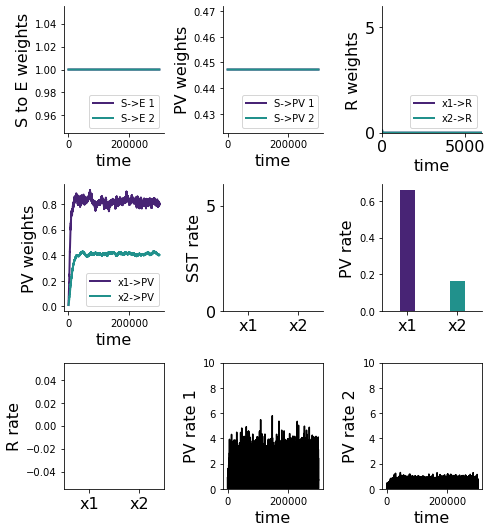

In [203]:
plt.figure(figsize=(7,7.5))
a0 = plt.subplot(331)
plt.plot(wES_monitor1, label='S->E 1', color =cm.viridis(.1),linewidth=2)
plt.plot(wES_monitor2, label='S->E 2',color =cm.viridis(.5),linewidth=2)
plt.ylabel('S to E weights',fontsize=16)
plt.xlabel('time',fontsize=16)
#plt.yticks([0,1],[0,1],fontsize=16)
#plt.xticks([0,10000],[0,10000],fontsize=16)
#plt.ylim(0,1.25)
#plt.xlim(0,11000)
plt.legend(loc='lower right')
a0.spines['top'].set_visible(False)
a0.spines['right'].set_visible(False)



#plt.legend(loc='lower right')
a6 = plt.subplot(332)
plt.plot(wPS_monitor1, label='S->PV 1', color =cm.viridis(.1),linewidth=2)
plt.plot(wPS_monitor2, label='S->PV 2',color =cm.viridis(.5),linewidth=2)
plt.ylabel('PV weights',fontsize=16)
plt.xlabel('time',fontsize=16)
#plt.yticks([0,1],[0,1],fontsize=16)
#plt.xticks([0,10000],[0,10000],fontsize=16)
#plt.ylim(0,1.25)
#plt.xlim(0,11000)
plt.legend(loc='lower right')
a6.spines['top'].set_visible(False)
a6.spines['right'].set_visible(False)



a1 = plt.subplot(333)
plt.plot(wRX1_monitor, label='x1->R', color =cm.viridis(.1),linewidth=2)
plt.plot(wRX2_monitor, label='x2->R',color =cm.viridis(.5),linewidth=2)
plt.ylabel('R weights',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.legend(loc='lower right')
plt.xlim(0,6000)
plt.xticks([0,5000],[0,5000],fontsize=16)
plt.ylim(0,6)
plt.yticks([0,5],[0,5],fontsize=16)
a1.spines['top'].set_visible(False)
a1.spines['right'].set_visible(False)

a5 = plt.subplot(334)
plt.plot(wPX1_monitor, label='x1->PV', color =cm.viridis(.1),linewidth=2)
plt.plot(wPX2_monitor, label='x2->PV',color =cm.viridis(.5),linewidth=2)
plt.ylabel('PV weights',fontsize=16)
plt.xlabel('time',fontsize=16)
#plt.yticks([0,1],[0,1],fontsize=16)
#plt.xticks([0,10000],[0,10000],fontsize=16)
#plt.ylim(0,1.25)
#plt.xlim(0,11000)
plt.legend(loc='lower right')
a5.spines['top'].set_visible(False)
a5.spines['right'].set_visible(False)


a3 = plt.subplot(335)
plt.bar([0,1],[SST_avg1,SST_avg2],color=[cm.viridis(.1),cm.viridis(.5)],width=0.3)  
plt.ylim(0,6)
plt.xlim(-0.5,1.5)
plt.yticks([0,5],[0,5],fontsize=16)
a3.spines['top'].set_visible(False)
a3.spines['right'].set_visible(False)
plt.ylabel('SST rate',fontsize=16)
plt.xticks([0,1],['x1','x2'],fontsize=16)

a2 = plt.subplot(336)
plt.bar([0,1],[PV_avg1,PV_avg2],color=[cm.viridis(.1),cm.viridis(.5)],width=0.3)
plt.ylabel('PV rate',fontsize=16)
plt.xticks([0,1],['x1','x2'],fontsize=16)
#plt.yticks([0,2],[0,2],fontsize=16)
a2.spines['top'].set_visible(False)
a2.spines['right'].set_visible(False)
#plt.ylim(0,2.3)
plt.xlim(-0.5,1.5)

a9 = plt.subplot(337)
plt.bar([0,1],[R_avg1,R_avg2],color=[cm.viridis(.1),cm.viridis(.5)],width=0.3)  
#plt.ylim(0,6)
plt.xlim(-0.5,1.5)
#plt.yticks([0,5],[0,5],fontsize=16)
a3.spines['top'].set_visible(False)
a3.spines['right'].set_visible(False)
plt.ylabel('R rate',fontsize=16)
plt.xticks([0,1],['x1','x2'],fontsize=16)

a10 = plt.subplot(338)
plt.plot(rP1, color = 'k')#,
         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))
plt.ylabel('PV rate 1',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.ylim(0,10)

a10 = plt.subplot(339)
plt.plot(rP2, color = 'k')#,
         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))
plt.ylabel('PV rate 2',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.ylim(0,10)

plt.tight_layout()
plt.savefig('./results_learnwPS.pdf', bbox_inches='tight',rasterized=True)


In [234]:
sigmas = np.arange(0.1,1.1,0.1)
PV_avg = np.empty_like(sigmas)
PV_std = np.empty_like(sigmas)
wPXs = np.empty_like(sigmas)
for i,sigma in enumerate(sigmas):
    _, PV_avg[i], _, _, _, PV_std[i], _, _, wPX, _, _, _, _, _, _,_ = run_network(sigma= sigma,wP=np.sqrt(20))
    wPXs[i] = wPX[-1]


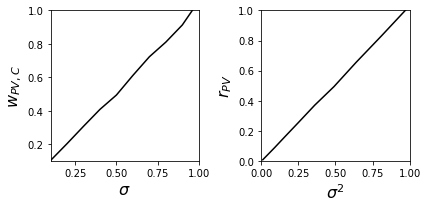

In [235]:
plt.figure(figsize=(6,3))
#plt.plot(sigmas, PV_avg*(1/np.sqrt(2)))
plt.subplot(121)
plt.plot(sigmas, wPXs, color='k')
# works for wP=3.0
plt.xlim(0.1,1.0)
plt.ylim(0.1,1.0)
#plt.xticks(np.arange(0.2,1.1,.2),[.2,.4,.6,.8,1.0],fontsize=12)
#plt.yticks(np.arange(0.2,1.1,.2),[.2,.4,.6,.8,1.0],fontsize=12)
plt.xlabel(r'$\sigma$',fontsize=16)
plt.ylabel(r'$w_{PV,C}$',fontsize=16)
plt.subplot(122)
plt.plot(sigmas**2, PV_avg, color='k')
plt.xlim(0,1.0)
plt.ylim(0,1.0)
#plt.xticks(np.arange(0,1.1,.2),[0,.2,.4,.6,.8,1.0],fontsize=12)
#plt.yticks(np.arange(0,1.1,.2),[0,.2,.4,.6,.8,1.0],fontsize=12)
plt.xlabel(r'$\sigma^2$',fontsize=16)
plt.ylabel(r'$r_{PV}$',fontsize=16)
plt.tight_layout()
plt.savefig('./PVscaling.png', bbox_inches='tight')


In [236]:
print((np.sqrt(10)*0.2)**2)
print((np.sqrt(10)**2*0.2**2))

0.40000000000000013
0.40000000000000013


In [231]:
print((np.sqrt(20)))
print((np.sqrt(2)*10))


4.47213595499958
14.142135623730951


In [178]:
1/np.sqrt(2)

0.7071067811865475

<ipython-input-26-d9cb0410cb73>:148: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('./pPEcircuit.pdf', bbox_inches='tight',rasterized=True)


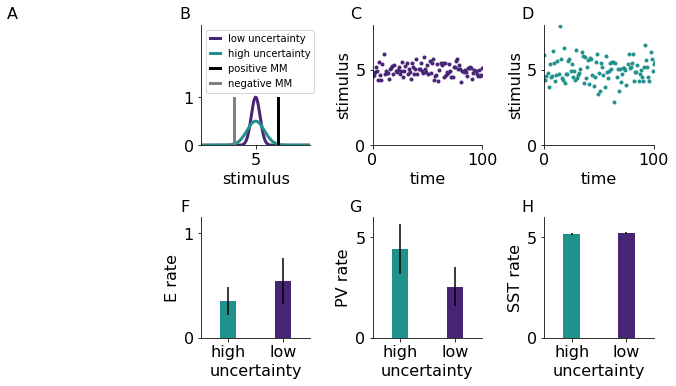

In [26]:
x_values = np.arange(0, 10, 0.001)
y1_values = stats.norm(Y1_mean, Y1_sigma)
y2_values = stats.norm(Y2_mean, Y2_sigma)

plt.figure(figsize=(9.5,5.5))

aa = plt.subplot(241)
aa.text(-0.1, 1.15, 'A', transform=aa.transAxes,
      fontsize=16, va='top', ha='right')
aa.spines['top'].set_visible(False)
aa.spines['right'].set_visible(False)
aa.spines['bottom'].set_visible(False)
aa.spines['left'].set_visible(False)
plt.xticks([])
plt.yticks([])

#a = plt.subplot(241)
a = plt.subplot(242)
a.text(-0.1, 1.15, 'B', transform=a.transAxes,
      fontsize=16, va='top', ha='right')
plt.plot(x_values, y2_values.pdf(x_values), color = cm.viridis(0.1),linewidth =3,label='low uncertainty')
plt.plot(x_values, y1_values.pdf(x_values), color = cm.viridis(0.5),linewidth =3,label='high uncertainty')
plt.plot(np.ones((100))*7,np.arange(0,1,0.01),color = 'k',linewidth=3, label = 'positive MM')
plt.plot(np.ones((100))*3,np.arange(0,1,0.01),color = 'gray',linewidth=3, label = 'negative MM')

ldg = plt.legend()
plt.xlim(0,10)
plt.ylim(0,2.5)
plt.yticks([0,1],[0,1],fontsize=16)
plt.xticks([5],[5],fontsize=16)
plt.xlabel('stimulus', fontsize = 16)
a.spines['top'].set_visible(False)
a.spines['right'].set_visible(False)
#a.legend(loc='center left', bbox_to_anchor=(1, 0.5),fancybox=True, shadow=False)
a.legend(loc='upper left',markerscale=0.5,handlelength=1.0)#, bbox_to_anchor=(1, 0.5))


#plt.legend(loc='lower right')
a6 = plt.subplot(243)
a6.text(-0.1, 1.15, 'C', transform=a6.transAxes,
      fontsize=16, va='top', ha='right')
#plt.plot(rY1,'.',color =cm.viridis(.3))#, label='Y1: mean: %.1f, sigma: %.1f'%(Y1_mean,Y1_sigma))
plt.plot(rY2,'.',color =cm.viridis(.1))#, label='Y2: mean: %.1f, sigma: %.1f'%(Y2_mean,Y2_sigma))
#plt.axhline(y=0.1, color=cm.viridis(.5), linestyle='-',linewidth=20)

plt.ylabel('stimulus',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.ylim(0,8)
plt.xlim(0,100)
plt.yticks([0,5],[0,5],fontsize=16)
plt.xticks([0,100],[0,100],fontsize=16)
a6.spines['top'].set_visible(False)
a6.spines['right'].set_visible(False)


a0 = plt.subplot(244)
a0.text(-0.1, 1.15, 'D', transform=a0.transAxes,
      fontsize=16, va='top', ha='right')
plt.plot(rY1,'.',color =cm.viridis(.5))#, label='Y1: mean: %.1f, sigma: %.1f'%(Y1_mean,Y1_sigma))
#plt.axhline(y=0.1, color=cm.viridis(.1), linestyle='-',linewidth=20)

#plt.plot(rY2,'.',color =cm.viridis(.5))#, label='Y2: mean: %.1f, sigma: %.1f'%(Y2_mean,Y2_sigma))
plt.ylabel('stimulus',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.yticks([0,5],[0,5],fontsize=16)
a0.spines['top'].set_visible(False)
a0.spines['right'].set_visible(False)
plt.ylim(0,8)
plt.xlim(0,100)
plt.xticks([0,100],[0,100],fontsize=16)

"""a7 = plt.subplot(255)
a7.text(-0.1, 1.15, 'E', transform=a7.transAxes,
      fontsize=16, va='top', ha='right')
plt.errorbar(mean_range,SST_rates_mean, yerr=SST_std_mean, color = 'k', fmt='.')

plt.xlabel(r'$\mu$',fontsize=15)
plt.ylabel('SST rate',fontsize=15)
plt.xticks([0,5],[0,5],fontsize=16)
plt.yticks([0,5],[0,5],fontsize=16)
plt.ylim(-0.2,6)
a7.spines['top'].set_visible(False)
a7.spines['right'].set_visible(False)
"""
ae = plt.subplot(245)
ae.spines['top'].set_visible(False)
ae.spines['right'].set_visible(False)
ae.spines['bottom'].set_visible(False)
ae.spines['left'].set_visible(False)
plt.xticks([])
plt.yticks([])

a1 = plt.subplot(246)
a1.text(-0.1, 1.15, 'F', transform=a1.transAxes,
      fontsize=16, va='top', ha='right')
plt.bar([0,1],[E_avg1_new,E_avg2_new],yerr=[E_std1_new,E_std2_new],color=[cm.viridis(.5),cm.viridis(.1)],width=0.3)  
plt.ylabel('E rate',fontsize=16)
plt.xticks([0,1],['high','low'],fontsize=16)
plt.yticks([0,1],[0,1],fontsize=16)
a1.spines['top'].set_visible(False)
a1.spines['right'].set_visible(False)
plt.ylim(0,1.15)
plt.xlim(-0.5,1.5)
plt.xlabel('uncertainty',fontsize=16)


a2 = plt.subplot(247)
a2.text(-0.1, 1.15, 'G', transform=a2.transAxes,
      fontsize=16, va='top', ha='right')
plt.bar([0,1],[PV_avg1_new,PV_avg2_new],yerr=[PV_std1_new,PV_std2_new],color=[cm.viridis(.5),cm.viridis(.1)],width=0.3)  
plt.ylabel('PV rate',fontsize=16)
plt.xticks([0,1],['high','low'],fontsize=16)
plt.yticks([0,5],[0,5],fontsize=16)
plt.ylim(0,6)
a2.spines['top'].set_visible(False)
a2.spines['right'].set_visible(False)
plt.xlim(-0.5,1.5)
plt.xlabel('uncertainty',fontsize=16)


a3 = plt.subplot(248)
a3.text(-0.1, 1.15, 'H', transform=a3.transAxes,
      fontsize=16, va='top', ha='right')
plt.bar([0,1],[SST_avg1_new,SST_avg2_new],yerr=[SST_std1_new,SST_std2_new],color=[cm.viridis(.5),cm.viridis(.1)],width=0.3)  
plt.ylim(0,6)
plt.xlim(-0.5,1.5)
plt.yticks([0,5],[0,5],fontsize=16)
a3.spines['top'].set_visible(False)
a3.spines['right'].set_visible(False)
plt.ylabel('SST rate',fontsize=16)
plt.xticks([0,1],['high','low'],fontsize=16)
plt.xlabel('uncertainty',fontsize=16)

"""
a3 = plt.subplot(2,5,10)
a3.text(-0.1, 1.15, 'I', transform=a3.transAxes,
      fontsize=16, va='top', ha='right')
plt.errorbar(sigma_range**2,PV_rates_sigma, yerr=PV_std_sigma, color = 'k',fmt='.')
plt.xlabel(r'$\sigma^2$',fontsize=15)
plt.ylabel('PV rate',fontsize=15)
plt.xticks([0.0,1.0],[0,1],fontsize=16)
plt.yticks([0,2],[0,2],fontsize=16)
a3.spines['top'].set_visible(False)
a3.spines['right'].set_visible(False)
"""
plt.tight_layout()

plt.savefig('./pPEcircuit.pdf', bbox_inches='tight',rasterized=True)

In [548]:
def run_nPEnetwork(mean= 5.0, sigma= 0.5, Rrate=None,wP=np.sqrt(20), w_init_PVX = 0.01, w_init_PVS = 0.01, w_init_R = 0.1, plastic=True, plastic_PX=True,plastic_PS=False, rectified=1):
    """
    Parameters
    ----------
    mean : float
        mean of the stimulus distribution
    sigma: float
        standard deviation of the stimulus distribution
    wP : float
        connection weight from R to PV and from SST to PV
    w_init_PV : float
        initial weight from Y1 to PV
    w_init_R : float
        initial weight from Y1 to R
    plastic : boolean
        truth value indicates whether plasticity is switched on or off   
        
    Returns
    ----------
    E_avg : float
        mean rate of error neuron
    PV_avg : float
        mean rate of PV
    SST_avg : float
        mean rate of SST
    R_avg : float
        mean rate of R
    wPX1_monitor : array of length t
        weight from X1 to PV over the course of the simulation
    wRX1_monitor : array of length t
        weight from X1 to R over the course of the simulation
    rE_monitor : array of length t
        rate of error neuron over the course of the simulation
    rS_monitor : array of length t
        rate of error neuron over the course of the simulation
    rP_monitor : array of length t
        rate of error neuron over the course of the simulation
    rY1 : array of length t
        whisker deflections over the course of the simulation
    """
    
    #sim parameters
    dt = 1
    T = 300000 # number of time steps

    # time constants
    tau_P = 1.0
    tau_S = 1.0
    tau_E = 1.0
    tau_R = 1.0

    # weights
    # to PV
    wPX1 = np.array([w_init_PVX]) # small intitial weights
    wPR = np.array([wP]) # small intitial weights
    if plastic_PS:
        wPS = np.array([w_init_PVS])
    else:
        wPS = np.array([wP])

    # to Representation neuron
    wRX1 = np.array([w_init_R]) # small intitial weight
    wRY1 = np.array([1.0])
    
    # to SST
    #wSR = np.array([1.0])
    wSY1 = np.array([1.0])

    # to E
    wEP = np.array([1.0])
    wES = np.array([1.0])
    wER = np.array([1.0])

    # nudging parameter
    beta_R = 0.1 
    beta_P = 0.1


    # inputs
    # sound
    rX1 = np.ones((T))

    # whisker
    Y1_mean = mean
    Y1_sigma = sigma

    rY1 = Y1_sigma*np.random.randn(T)+Y1_mean
    
    # test
    if Rrate is None:
        rR = np.ones(T)*Y1_mean
    else:
        rR = np.ones(T)*Rrate
        
    #learning rate
    eta_R = 0.1
    eta_P = 0.001
    eta_ES = 0.001

    #initial rates
    rP = 0.0#phi_square(rB[0])
    rS = 0.0
    rE = 0.0
    #rR = 0.0

    # monitors
    rP_monitor = np.empty((T))
    rE_monitor = np.empty((T))
    rS_monitor = np.empty((T))
    rR_monitor = np.empty((T))

    wPX1_monitor = np.empty((T))
    wRX1_monitor = np.empty((T))
    wPS_monitor = np.empty((T))
    wES_monitor = np.empty((T))


    for t in range(T):
        drS = (-rS + phi(wSY1 * rY1[t],case=rectified))/tau_S
        drP = (-rP + phi_square(((1-beta_P)*(wPX1 * rX1[t]) + beta_P*(wPR * rR[t] - wPS * rS))))/tau_P
        drE = (-rE + phi(1.0/(0.2 + (wEP * rP)) * (wER * rR[t] - wES * rS),case=rectified))/tau_E

        #drR = (-rR + phi_RL((wRX1 * rX1[t]) + (wRE_P * rE_P) - (wRE_N * rE_N)))/tau_R # no convex combination, input from error neuron
                
    
        # store monitors
        rP_monitor[t] = rP
        rS_monitor[t] = rS
        rE_monitor[t] = rE
        #rR_monitor[t] = rR
        wPX1_monitor[t] = wPX1
        wRX1_monitor[t] = wRX1
        wPS_monitor[t] = wPS
        wES_monitor[t] = wES


        # rate changes
        #rR += dt*drR
        rS += dt*drS
        rP += dt*drP
        rE += dt*drE

        # weight changes
        dwPX1 = plastic_PX * eta_P * ((rP - phi_square(wPX1*rX1[t])) * rX1[t])
        #dwPX1 = plastic * eta_P * (((wPY1 * rY1[t] - wPS * rS[t]) - (wPX1*rX1[t])) * rX1[t])
        


        dwRX1 = plastic * eta_R * ((rR[t] - (wRX1*rX1[t])) * rX1[t])
        #dwPS = plastic_PS * eta_P * (wPY1 * rY1[t] - wPS * rS[t])*rS[t]
        #dwES = plastic * eta_ES * ((wEY1 * rY1[t] - wES * rS))*rS
        
        #wRE_P += plastic * eta_RE * (wRE_P*rE_P - wRE_N*rE_N) * rE_P
        #wRE_N += plastic * eta_RE * (wRE_P*rE_P - wRE_N*rE_N) * rE_N

        wPX1 += dt*dwPX1
        wRX1 += dt*dwRX1
        #wPS += dt*dwPS
        #wES += dt*dwES

    
    PV_avg = np.mean(rP_monitor[100:])
    SST_avg = np.mean(rS_monitor[100:])
    E_avg = np.mean(rE_monitor[100:])
    R_avg = np.mean(rR_monitor[100:])
    PV_std = np.std(rP_monitor[100:])
    SST_std = np.std(rS_monitor[100:])
    E_std = np.std(rE_monitor[100:])
    #R_std = np.std(rR_monitor[100:])
    
    rR_monitor = rR
    
    results = {
    'PV_avg' : np.mean(rP_monitor[100:]),
    'SST_avg': np.mean(rS_monitor[100:]),
    'E_avg' : np.mean(rE_monitor[100:]),
    'R_avg' : np.mean(rR_monitor[100:]),
    'PV_std' : np.std(rP_monitor[100:]),
    'SST_std': np.std(rS_monitor[100:]),
    'E_std' : np.std(rE_monitor[100:]),
    'R_std' : np.std(rR_monitor[100:]),
    'wPX1' : wPX1_monitor,
    'wRX1' : wRX1_monitor, 
    'wPS' : wPS_monitor, 
    'wES' : wES_monitor, 
    #'wRE' : wRE_monitor, 
    'rE' : rE_monitor, 
    'rS' : rS_monitor, 
    'rP' : rP_monitor, 
    'rR' : rR_monitor, 
    'rY1' : rY1,
    }
    
    return results
    

In [549]:
Y1_mean = 5.0
Y2_mean = 5.0
Y1_sigma = 0.8
Y2_sigma = 0.4
resultsn1 = run_nPEnetwork(mean= Y1_mean,sigma=Y1_sigma,wP=np.sqrt(20))#4.4)
resultsn2 = run_nPEnetwork(mean= Y2_mean,sigma=Y2_sigma,wP=np.sqrt(20))#4.4)

<ipython-input-322-cad3f6f51d74>:34: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('./PVratesandweights_%s.png'%name, bbox_inches='tight',rasterized=True)


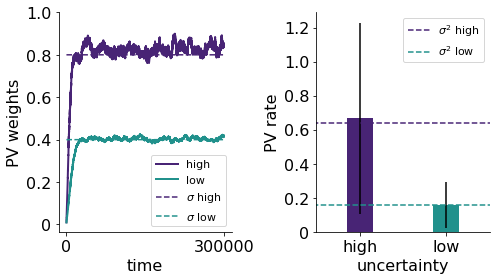

In [550]:
plot_PVratesandweights(resultsn1,resultsn2,'nPE')


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


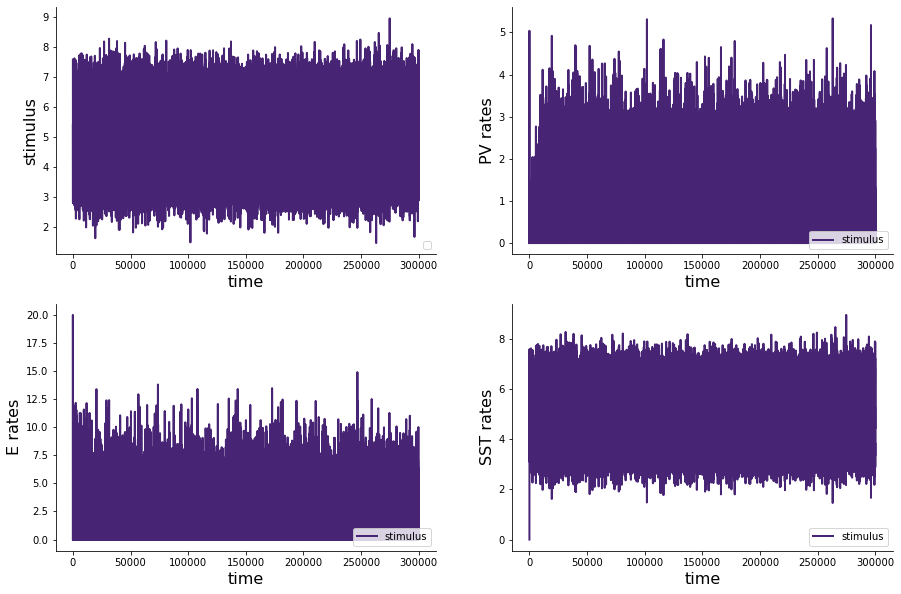

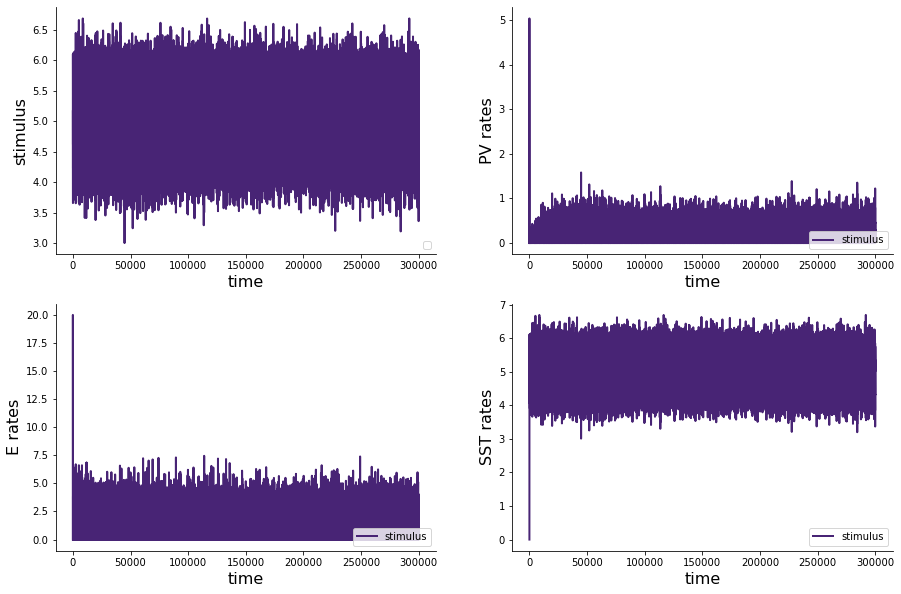

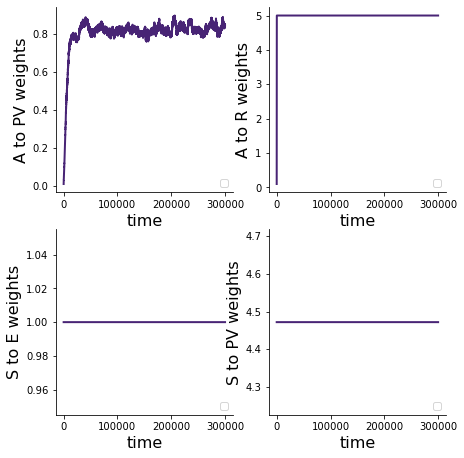

In [551]:
plot_all_rates(resultsn1,name='nPE')
plot_all_rates(resultsn2,name='nPE2')

plot_all_weights(resultsn1,name='nPE')